In [1]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 331M/331M [00:17<00:00, 22.7MB/s]
100% 331M/331M [00:17<00:00, 20.3MB/s]


In [2]:
import zipfile
zip_ref=zipfile.ZipFile('/content/utkface-new.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential,Model,layers
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Input
from tqdm.notebook import tqdm
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
os.listdir('/content/utkface_aligned_cropped')

['UTKFace', 'crop_part1']

In [5]:

utk_folder = os.path.join('utkface_aligned_cropped', 'UTKFace')
crop_folder = os.path.join('utkface_aligned_cropped', 'crop_part1')

# Count the number of files in each folder
num_utk_images = len(os.listdir(utk_folder))
num_crop_images = len(os.listdir(crop_folder))

print(f"Number of dog images: {num_utk_images}")
print(f"Number of cat images: {num_crop_images}")

Number of dog images: 23708
Number of cat images: 9780


In [6]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [7]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(folder_path)):
    image_path = os.path.join(folder_path, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [8]:
df = pd.DataFrame({'age':age_labels,'gender':gender_labels,'image':image_paths})

In [9]:
df

,age,gender,image
0,51,0,/content/utkface_aligned_cropped/UTKFace/51_0_...
1,55,1,/content/utkface_aligned_cropped/UTKFace/55_1_...
2,50,0,/content/utkface_aligned_cropped/UTKFace/50_0_...
3,53,1,/content/utkface_aligned_cropped/UTKFace/53_1_...
4,1,0,/content/utkface_aligned_cropped/UTKFace/1_0_3...
...,...,...,...
23703,27,0,/content/utkface_aligned_cropped/UTKFace/27_0_...
23704,29,1,/content/utkface_aligned_cropped/UTKFace/29_1_...
23705,61,0,/content/utkface_aligned_cropped/UTKFace/61_0_...
23706,26,0,/content/utkface_aligned_cropped/UTKFace/26_0_...


In [10]:
df.shape

(23708, 3)

In [11]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

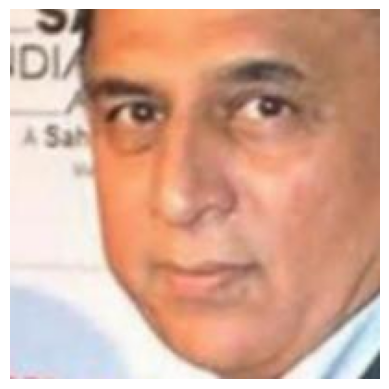

In [12]:
img_path = df['image'][0]
img = load_img(img_path)

# Display the image
plt.axis('off')  # Turn off axis
plt.imshow(img)   # Display the image
plt.show()

<ipython-input-14-7452d86f8334>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'])


<Axes: xlabel='age', ylabel='Density'>

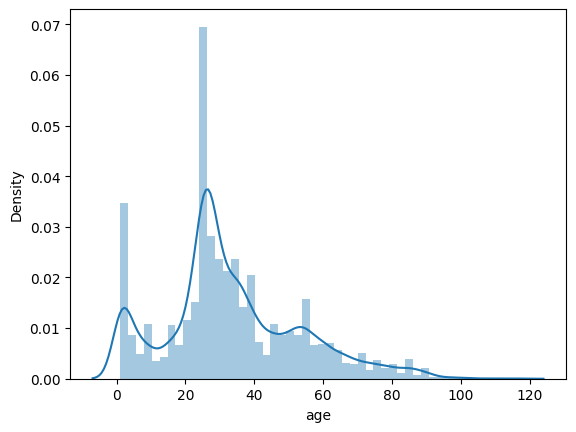

In [14]:
sns.distplot(df['age'])

In [15]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, age, gender, file in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [16]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [17]:
from PIL import Image

In [18]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [19]:
X.shape

(23708, 128, 128, 1)

In [20]:
# normalize the images
X = X/255.0

In [21]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [22]:
input_shape = (128, 128, 1)

In [23]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

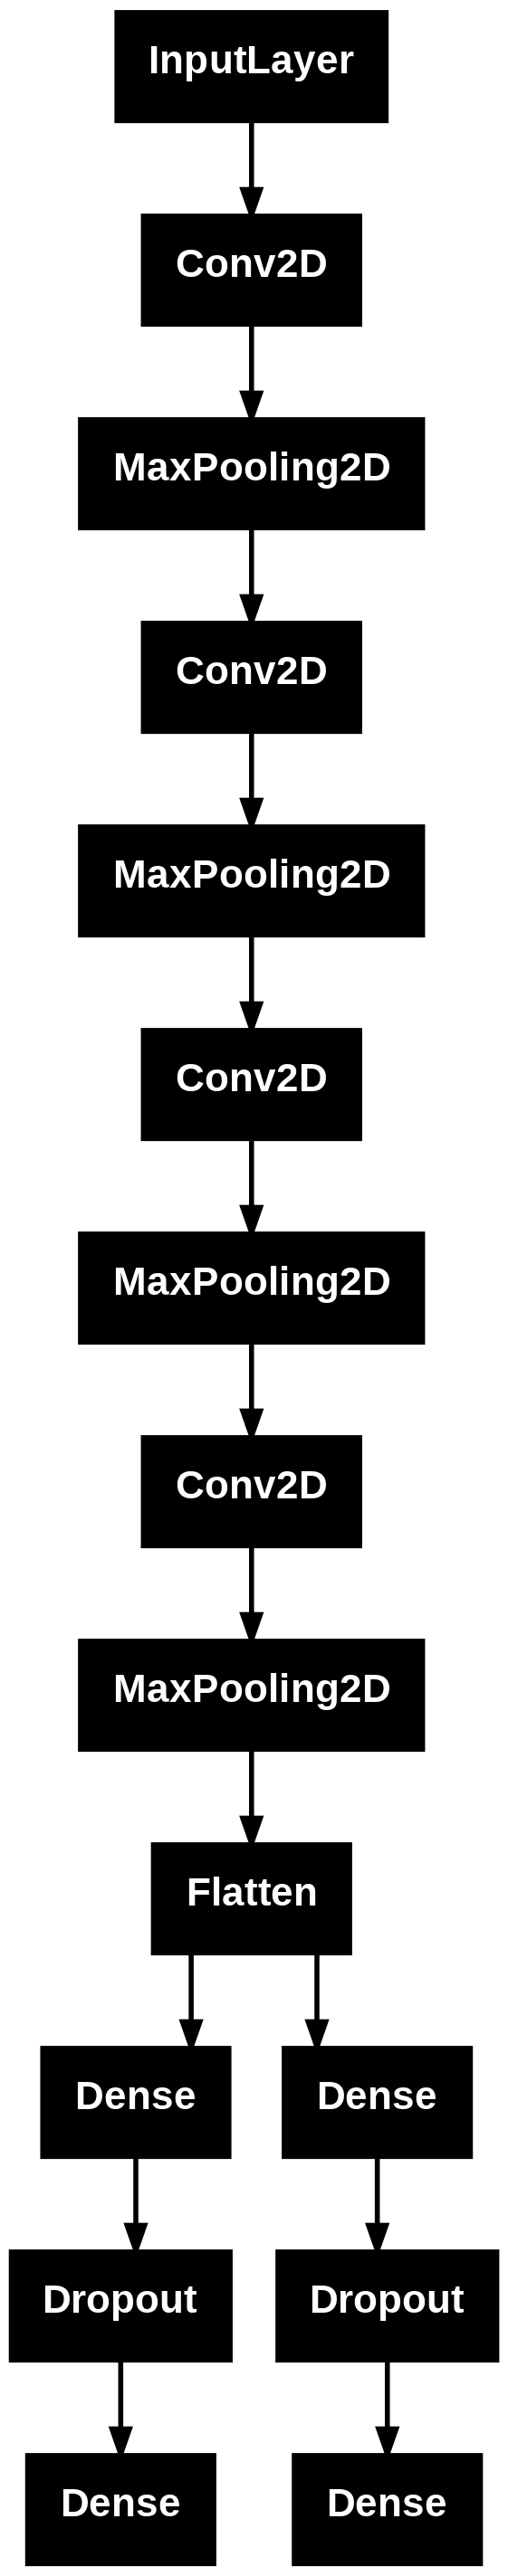

In [24]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 14, 14, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 12, 12, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 6, 6, 256)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 9216)           │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      2,359,552 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │      2,359,552 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_out (Dense)        │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_out (Dense)           │ (None, 1)              │            257 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:

# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - age_out_loss: 16.5775 - age_out_mae: 16.5775 - gender_out_accuracy: 0.5221 - gender_out_loss: 0.6983 - loss: 17.2758 - val_age_out_loss: 14.0855 - val_age_out_mae: 14.1080 - val_gender_out_accuracy: 0.7039 - val_gender_out_loss: 0.5847 - val_loss: 14.6912
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - age_out_loss: 12.0995 - age_out_mae: 12.0995 - gender_out_accuracy: 0.7127 - gender_out_loss: 0.5589 - loss: 12.6584 - val_age_out_loss: 10.3937 - val_age_out_mae: 10.4051 - val_gender_out_accuracy: 0.7811 - val_gender_out_loss: 0.4552 - val_loss: 10.8590
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - age_out_loss: 9.9873 - age_out_mae: 9.9873 - gender_out_accuracy: 0.7821 - gender_out_loss: 0.4662 - loss: 10.4535 - val_age_out_loss: 9.0475 - val_age_out_mae: 9.0739 - val_gender_out_accuracy: 0.8163 - val_gender_out_loss: 0.3928 - val_loss: 9.4669
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - age_out_loss:

In [33]:
print(history.history.keys())

dict_keys(['age_out_loss', 'age_out_mae', 'gender_out_accuracy', 'gender_out_loss', 'loss', 'val_age_out_loss', 'val_age_out_mae', 'val_gender_out_accuracy', 'val_gender_out_loss', 'val_loss'])


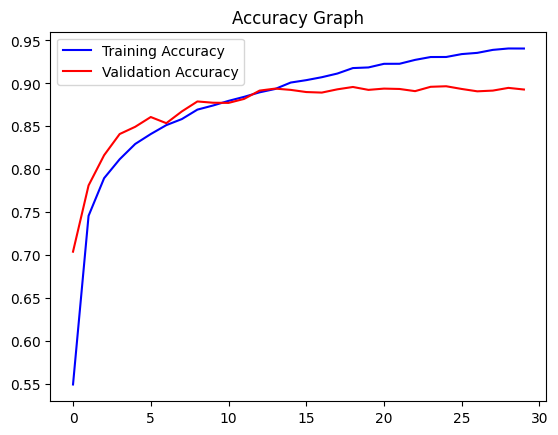

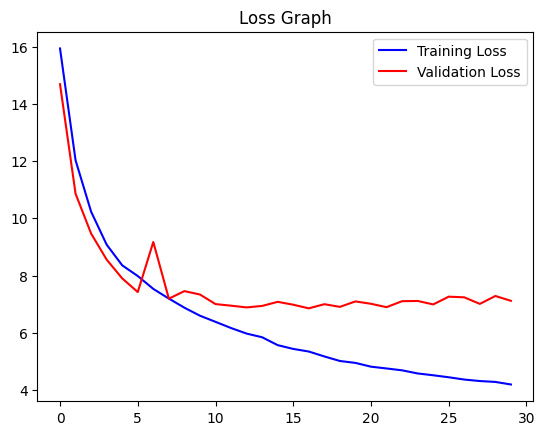

In [28]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


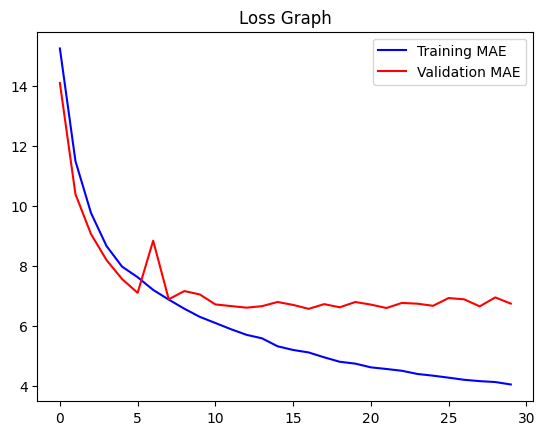

In [29]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 65
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicted Gender: Male Predicted Age: 53


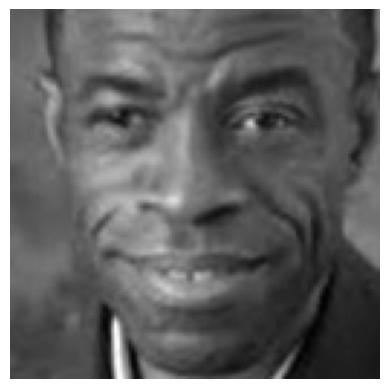

In [30]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Gender: Male Predicted Age: 39


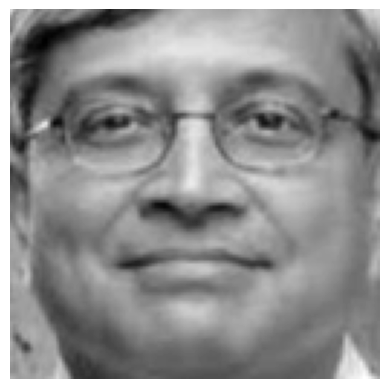

In [31]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');